In [1]:
from sklearn.utils import resample
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
sns.set()

In [2]:
fraud_data = pd.read_csv("creditcard.csv")
fraud_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print("Shape",fraud_data.shape)
fraud_data.Class.value_counts()

Shape (284807, 31)


0    284315
1       492
Name: Class, dtype: int64

In [4]:
# separating variables from the class.
features = fraud_data.drop("Class",axis=1)
labels = fraud_data.Class

#### Importing packages.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.model_selection import train_test_split

In [10]:
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=0.3,random_state=0)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Initializing the model and hyperparameters tuning.
- GridsearchCV will iterate through all given parameters (distributative manner) to check all of them.
- It will save the best parameters and use them to predict for the model.
- Usually it is useless to hypertune LogisticRegression since it won't bring too much improvement to the model. Other models, (tree based models) could benefit a lot from hypertuning for example.

In [15]:
logreg = LogisticRegression(random_state=0)
params = {"C": [0.01,0.1,1,10,100],'penalty':['l1','l2']}
cv = KFold(n_splits=5,shuffle=False)

In [16]:
clf = GridSearchCV(estimator=logreg,param_grid=params,cv = cv,
                   scoring='f1_macro',n_jobs=-1)
clf.fit(X_train_scaled,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='f1_macro')

#### Note: 
Classification report is done based on the p>50% threshold.

In [17]:
y_pred = clf.predict(X_test_scaled)
print("Confusion matrix")
print(confusion_matrix(y_test,y_pred))
print("Classification report \n",classification_report(y_test,y_pred))
print("Accuracy ({})".format(accuracy_score(y_test,y_pred)))

Confusion matrix
[[85285    12]
 [   50    96]]
Classification report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85297
           1       0.89      0.66      0.76       146

    accuracy                           1.00     85443
   macro avg       0.94      0.83      0.88     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy (0.9992743700478681)


#### Best parameters from the GridSearchCV.

In [21]:
print("Best parameters {}".format(clf.best_params_))
print("Best F1_Macro average {}".format(clf.best_score_))

Best parameters {'C': 10, 'penalty': 'l2'}
Best F1_Macro average 0.8699409590524709


#### Trying with a tree based model.
- Random Classifier then we do upsampling/downsampling techniques and use the logistic regression model (only).
- Baseline model without any fine tuning

In [22]:
from sklearn.ensemble import RandomForestClassifier
tree_classifier = RandomForestClassifier(random_state=1)
tree_classifier.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [23]:
y_pred = tree_classifier.predict(X_test)
print("Confusion matrix")
print(confusion_matrix(y_test,y_pred))
print("Classification report \n",classification_report(y_test,y_pred))
print("Accuracy ({})".format(accuracy_score(y_test,y_pred)))

Confusion matrix
[[85290     7]
 [   32   114]]
Classification report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85297
           1       0.94      0.78      0.85       146

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy (0.9995435553526912)


#### Over and Undersampling.
- Since our data is large, Oversampling is not an optimal tool.
- Optimally, to avoid losing a lot of information, one could implement Under and Oversampling at the same time.

In [89]:
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

In [25]:
random_under_sampler = RandomUnderSampler(sampling_strategy = 0.5, random_state=0)
random_over_sampler = RandomOverSampler(sampling_strategy = 0.25,random_state=0)
borderSMOTE = BorderlineSMOTE(sampling_strategy=0.25,random_state=0)
smote = SMOTE(sampling_strategy=0.25,random_state=0)

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

In [49]:
def draw_confusion(confusion_matrix,model_name):
    sns.heatmap(pd.DataFrame(confusion_matrix,index=["Act.False","Act.True"],columns=["Pred.False","Pred.True"]),annot=True,fmt='d')
    plt.title("Confusion Matrix of {}".format(model_name))
    plt.show()

In [68]:
def logreg_model(X_train,X_test,y_train,y_test):
    model = LogisticRegression(random_state=0,C=10,max_iter=4000)    
    model.fit(X_train,y_train)
    predicted_results = model.predict(X_test)
    print('Classification report for log:\n', classification_report(y_test, predicted_results))
    #confus matrix
    conf_mat = confusion_matrix(y_test, predicted_results)
    draw_confusion(conf_mat,'logreg')
    plot_precision_recall_curve(model,X_test,y_test)
    plt.title("P-R Curve")
    plt.show()
    plot_roc_curve(model,X_test,y_test)
    plt.title("ROC Curve")
    plt.show()
    return model    

In [62]:
def sampled_logreg(model,X_train,y_train):
    # sampling using a strategy
    X_train_sampled,y_train_sampled = model.fit_sample(X_train,y_train)
    # training the model on the sampling strategy and testing
    return X_train_sampled,y_train_sampled

In [37]:
from IPython.display import Markdown, display

In [44]:
dict_sampler = {'OVER':random_over_sampler,'UNDER':random_under_sampler,'SMOTE':smote,'BORDERsmote':borderSMOTE}

#### Logistic Regression model using OVER-Sampling

Counter({0: 199018, 1: 49754})
Classification report for log:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     85297
           1       0.21      0.85      0.34       146

    accuracy                           0.99     85443
   macro avg       0.60      0.92      0.67     85443
weighted avg       1.00      0.99      1.00     85443



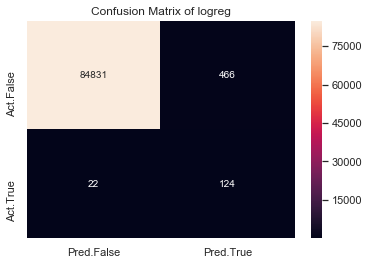

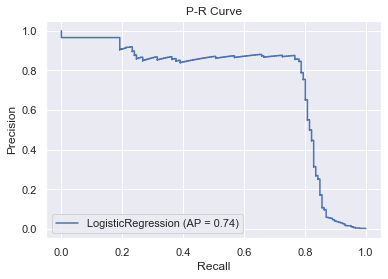

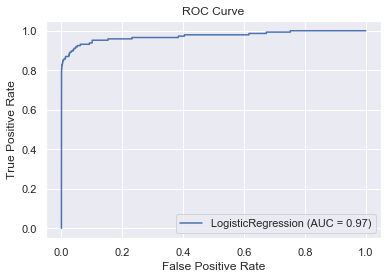

#### Logistic Regression model using UNDER-Sampling

Counter({0: 692, 1: 346})
Classification report for log:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     85297
           1       0.10      0.86      0.17       146

    accuracy                           0.99     85443
   macro avg       0.55      0.92      0.58     85443
weighted avg       1.00      0.99      0.99     85443



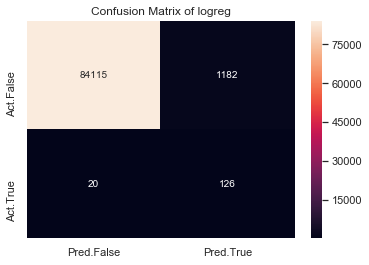

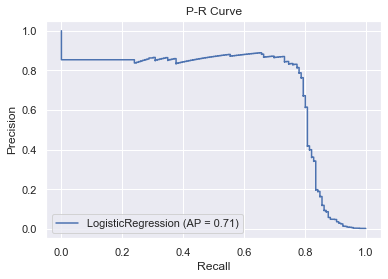

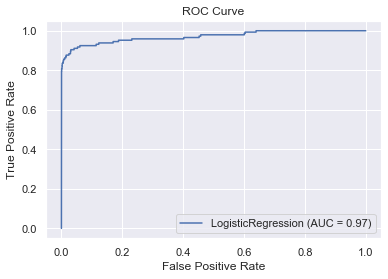

#### Logistic Regression model using SMOTE-Sampling

Counter({0: 199018, 1: 49754})
Classification report for log:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85297
           1       0.35      0.83      0.49       146

    accuracy                           1.00     85443
   macro avg       0.67      0.91      0.74     85443
weighted avg       1.00      1.00      1.00     85443



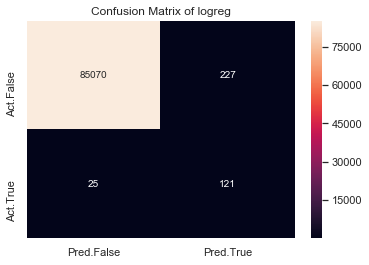

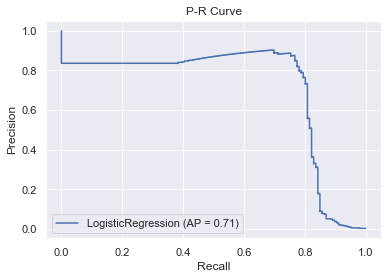

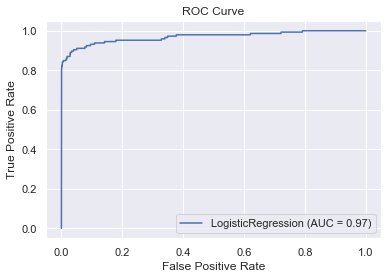

#### Logistic Regression model using BORDERsmote-Sampling

Counter({0: 199018, 1: 49754})
Classification report for log:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85297
           1       0.61      0.82      0.70       146

    accuracy                           1.00     85443
   macro avg       0.80      0.91      0.85     85443
weighted avg       1.00      1.00      1.00     85443



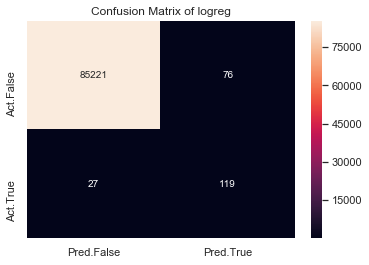

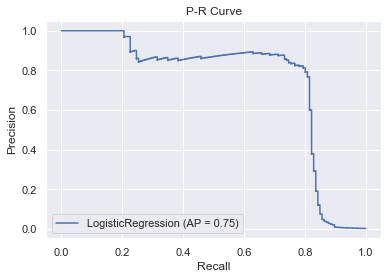

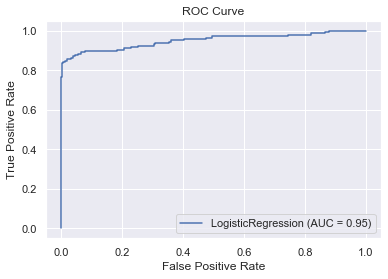

In [69]:
scaler = StandardScaler()
for name,model in dict_sampler.items():
    display(Markdown("#### Logistic Regression model using {}-Sampling".format(name)))
    X_sampled,y_sampled = sampled_logreg(model,X_train,y_train)
    print(Counter(y_sampled))
    X_train_sampled_scaled = scaler.fit_transform(X_sampled)
    X_test_scaled = scaler.transform(X_test)
    logreg_model(X_train_sampled_scaled,X_test_scaled,y_sampled,y_test)


In [87]:
def plot_data(X, y,alpha=0.5):
    plt.scatter(X.loc[y == 0, 'V1'], X.loc[y == 0, 'V2'], label="Class #0", alpha=alpha, linewidth=0.15)
    plt.scatter(X.loc[y == 1, 'V1'], X.loc[y == 1, 'V2'], label="Class #1", alpha=alpha, linewidth=0.15, c='orange')
    plt.legend()
    return plt.show()

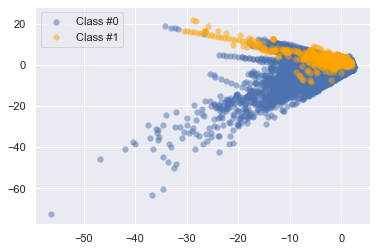

In [88]:
plot_data(features,labels)

In [90]:
smotetomek = SMOTETomek(0.5)
X_smotek,Y_smotek = smotetomek.fit_sample(X_train,y_train)

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


In [91]:
Counter(Y_smotek)

Counter({0: 198292, 1: 98783})

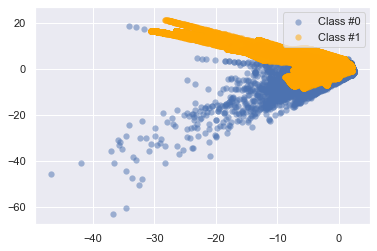

In [94]:
plot_data(X_smotek,Y_smotek)

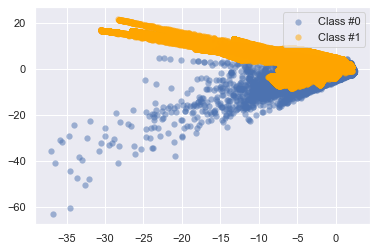

In [95]:
smotenn = SMOTEENN(sampling_strategy=0.5)
X_smoteenn,Y_smoteenn = smotenn.fit_sample(X_train,y_train)
Counter(Y_smoteenn)
plot_data(X_smoteenn,Y_smoteenn)

Classification report for log:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85297
           1       0.26      0.84      0.40       146

    accuracy                           1.00     85443
   macro avg       0.63      0.92      0.70     85443
weighted avg       1.00      1.00      1.00     85443



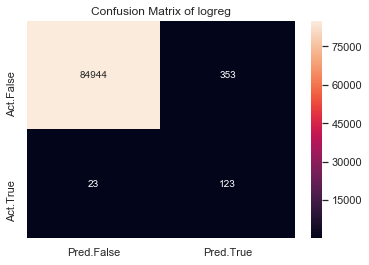

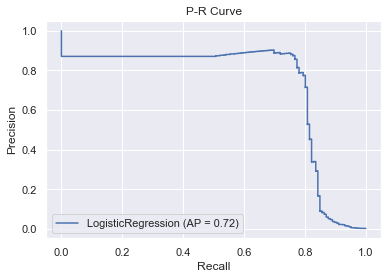

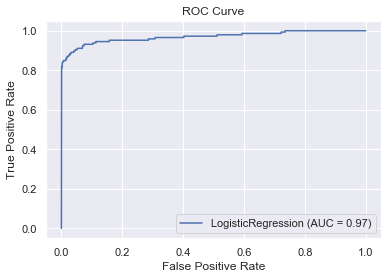

LogisticRegression(C=10, max_iter=4000, random_state=0)

In [96]:
scaler = StandardScaler()
X_smoteen_scaled = scaler.fit_transform(X_smoteenn)
X_smoteentest_scaled = scaler.transform(X_test)
logreg_model(X_smoteen_scaled,X_smoteentest_scaled,Y_smoteenn,y_test)